In [1]:
# coding: utf-8
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import et cleaning de la data

* informations sur la population par département => estim-pop-dep-sexe-gca-1975-2018.xls
* informations sur les honoraires par département => honoraires_departement_en_2016.xls
* Nous allons traiter l'année 2016

In [2]:
df = pd.read_excel('./estim-pop-dep-sexe-gca-1975-2018.xls', sheet_name='2016', skiprows=4)
df.rename(columns={'Unnamed: 0':'CODE', 'Unnamed: 1':'DEPARTEMENT',
                  '0 à 19 ans':'[0,19]', '20 à 39 ans':'[20,39]',
                  '40 à 59 ans':'[40,59]', '60 à 74 ans':'[60,74]',
                  '75 ans et plus':'75+', 'Total':'TOTAL'}, inplace=True)
df_ens = df.iloc[:96, :8]

In [3]:
df = pd.read_excel('honoraires_departement_en_2016.xls', sheet_name='Spécialistes')
df.rename(columns={'Spécialistes': 'SPECIALISTES',
                   'DEPARTEMENT': 'CODE',
                   'HONORAIRES SANS DEPASSEMENT (Euros)': 'HONORAIRES',
                   'DEPASSEMENTS (Euros)': 'DEPASSEMENTS'}, inplace=True)

In [4]:
def delete_nc_and_0(df):
    df = df[df['HONORAIRES'] != 'nc']
    df = df[df['DEPASSEMENTS'] != 'nc']
    df = df[df['EFFECTIFS'] != 0]
    return df

def _clean_spe(df):
    #Comparer la rapidité
    #df = df[~df['SPECIALISTES'].str.contains(r'^TOTAL.*')]
    df = df.where(~df['SPECIALISTES'].str.contains(r'^TOTAL.*')).dropna()
    df['SPECIALISTES'] = df['SPECIALISTES'].str.extract(r'\d*-*([\D^\(]+)')
    return df

def _clean_totaux(df):
    mask_totaux = df['CODE'].str.contains(r'^TOTAL.*')
    return df[~mask_totaux]

def _clean_dept(df):
    df['CODE'] = df['CODE'].str.extract(r'\D*([\dB?A?]+)')
    return df.where(~df['CODE'].str.contains(r'[\dB?A?]{3}')).dropna()

def clean_data(df):
    df = delete_nc_and_0(df)
    df = _clean_spe(df)
    df = _clean_totaux(df)
    df = _clean_dept(df)
    return df

def compute_ratio_depas(df):
    df['RATIO_DEPASSEMENTS'] = df['DEPASSEMENTS'] / (df['DEPASSEMENTS'] + df['HONORAIRES'])
    df['RATIO_DEPASSEMENTS'] = pd.to_numeric(df['RATIO_DEPASSEMENTS'], errors='coerce')
    del df['DEPASSEMENTS']
    del df['HONORAIRES']
    return df

def compute_hab_par_med_spe(df):
    df['HABITANTS/MEDECIN_SPE'] = df['TOTAL'] / df['EFFECTIFS']
    return df

In [5]:
df_clean = clean_data(df)
df_clean = compute_ratio_depas(df_clean)
df_clean_merge = df_clean.merge(df_ens, left_on='CODE', right_on='CODE', how='left')
df_clean_merge = compute_hab_par_med_spe(df_clean_merge)

## Ratio de dépassements par spécialités

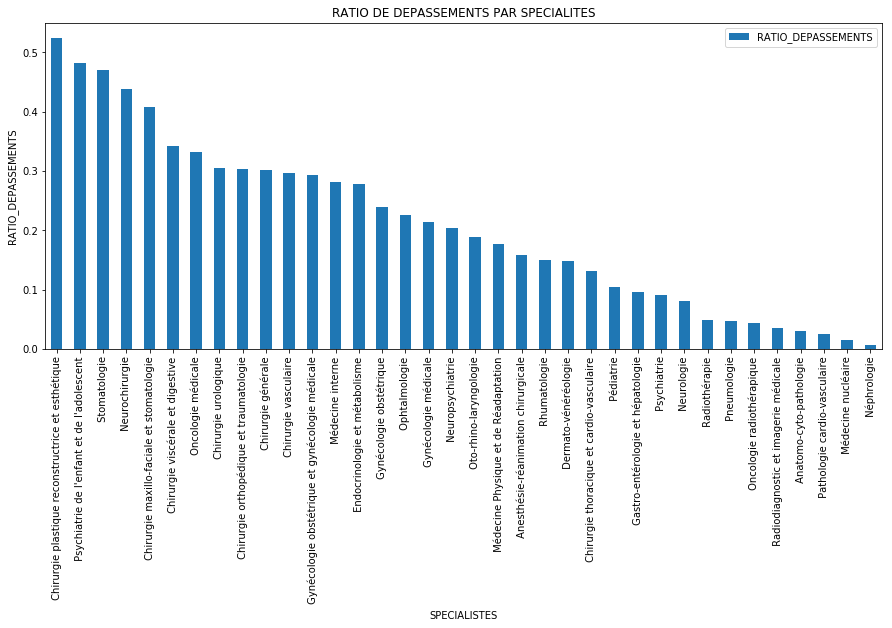

In [6]:
df_par_spe = pd.DataFrame(df_clean_merge.groupby(['SPECIALISTES'])['RATIO_DEPASSEMENTS'].mean())
df_par_spe = df_par_spe.sort_values(by='RATIO_DEPASSEMENTS', ascending=False)
df_par_spe.plot.bar(figsize=(15,6))
plt.title('RATIO DE DEPASSEMENTS PAR SPECIALITES')
plt.ylabel('RATIO_DEPASSEMENTS')
plt.show()

### Observation:
**J'aurais dû faire Chirurgien plastique!!!**

## Ratio de dépassements par départements

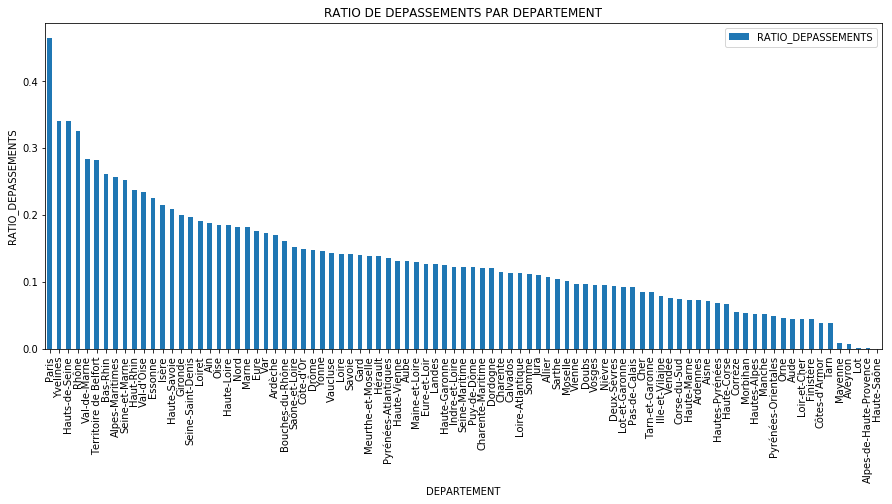

In [7]:
df_par_dep = pd.DataFrame(df_clean_merge.groupby(['DEPARTEMENT'])['RATIO_DEPASSEMENTS'].mean())
df_par_dep = df_par_dep.sort_values(by='RATIO_DEPASSEMENTS', ascending=False)
df_par_dep.plot.bar(figsize=(15,6))
plt.title('RATIO DE DEPASSEMENTS PAR DEPARTEMENT')
plt.ylabel('RATIO_DEPASSEMENTS')
plt.show()

### Observation:
**Qui aurait pu croire que Paris serait premier ?**

## Ratio de dépassements par spécialités en fonction du nombre d'habitants par médecins

* En abscisse : le nombre d'habitants par médecins (calculé par départements)
* En ordonnée : le ratio de dépassements (calculé par départements)

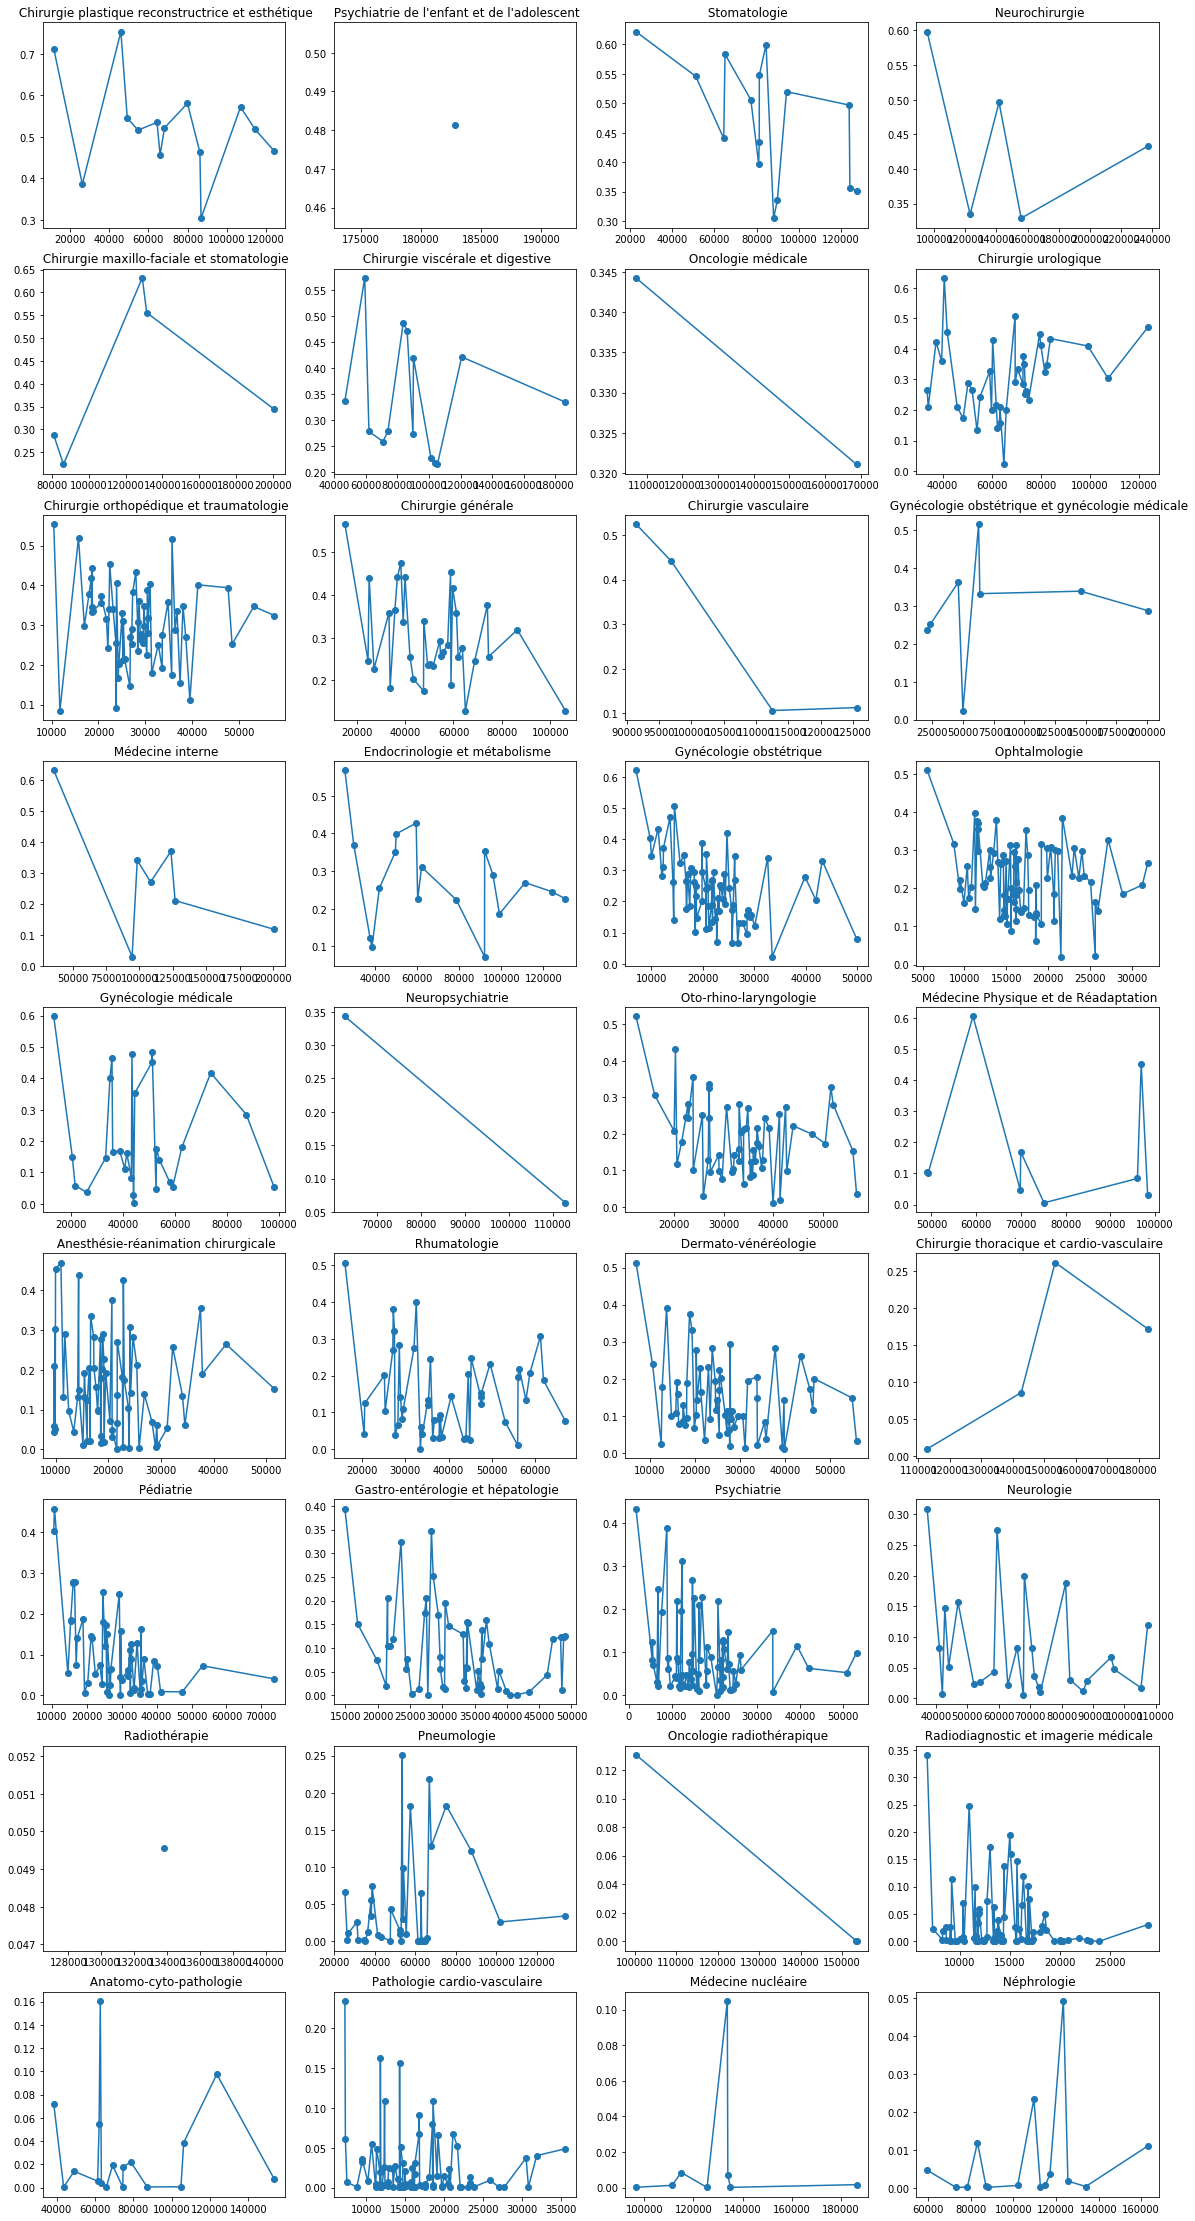

In [9]:
cat_spe = df_par_spe.index
plt.figure(figsize=(20,40))
for i, spe in enumerate(cat_spe):
    plt.subplot(9,4, 1+i)
    df_tmp = df_clean_merge[df_clean_merge['SPECIALISTES'] == spe]
    df_tmp = df_tmp.sort_values(by='HABITANTS/MEDECIN_SPE')
    plt.plot(df_tmp['HABITANTS/MEDECIN_SPE'],df_tmp['RATIO_DEPASSEMENTS'], 'o-')
    plt.title(f'{spe}')

### Observation:
**Pas de liens identifiés**

### Densité de spécialistes en pathologies cardio-vasculaire par rapport à la densité de personnes agées

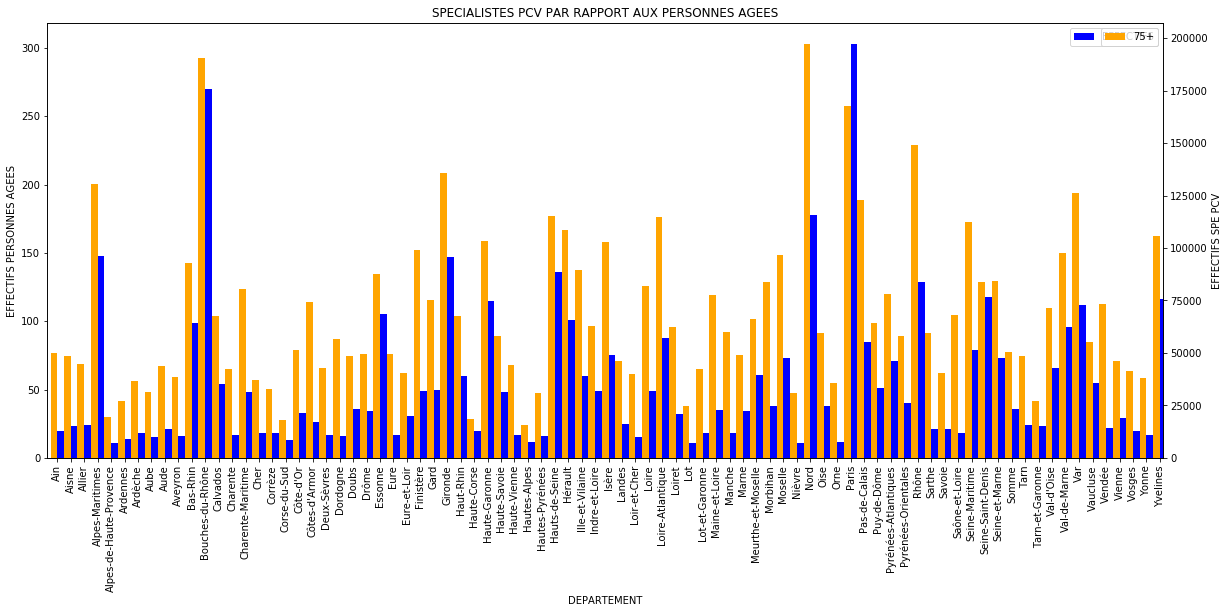

In [10]:
df_pcv = df_clean_merge[df_clean_merge['SPECIALISTES'].str.contains('Pathologie cardio-vasculaire')]
df_75_par_dep = pd.DataFrame(df_pcv.groupby(['DEPARTEMENT'])['75+'].mean())
df_eff_par_dep = pd.DataFrame(df_pcv.groupby(['DEPARTEMENT'])['EFFECTIFS'].mean())
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
df_eff_par_dep.plot(kind='bar', color='blue', ax=ax, position=0)
df_75_par_dep.plot(kind='bar', color='orange', ax=ax2, position=1)

ax.set_ylabel('EFFECTIFS PERSONNES AGEES')
ax2.set_ylabel('EFFECTIFS SPE PCV')
plt.title('SPECIALISTES PCV PAR RAPPORT AUX PERSONNES AGEES')
plt.show()